In [1]:
# Install pyyaml and ensure PyTorch and torchvision are installed
!pip install pyyaml
!pip install --upgrade torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import torch
import torchvision
import torch.utils.data
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import torchvision.transforms.functional as F
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import cv2


In [3]:
# Install Roboflow library
!pip install roboflow

# Import Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="A2wycrFsDr1E3JqnNRlT")
project = rf.workspace("capstone-p9zrm").project("palm-tree-jkpzn")
version = project.version(1)
dataset = version.download("yolov8")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.9/80.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.3 MB/s eta 0:00:00
  Attempting uninstall: idna
    Found existing installation: idna 3.10
    Uninstalling idna-3.10:
      Successfully uninstalled idna-3.10
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to palm-tree-1 in yolov8:: 100%|██████████| 1822/1822 [00:00<00:00, 7388.25it/s]


In [4]:
# List the contents of the dataset directory
!ls {dataset.location}


data.yaml  README.dataset.txt  README.roboflow.txt  test  train  valid


In [19]:
class PalmTreeDataset(Dataset):

    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms

        imgs = list(sorted(os.listdir(os.path.join(root, "images"))))
        labels = list(sorted(os.listdir(os.path.join(root, "labels"))))

        # Filter out images without annotations
        self.imgs = []
        self.labels = []
        for img_file, label_file in zip(imgs, labels):
            label_path = os.path.join(root, "labels", label_file)
            with open(label_path, 'r') as f:
                lines = f.readlines()
                if not lines or all(line.strip() == '' for line in lines):
                    continue  # Skip images with no annotations
            self.imgs.append(img_file)
            self.labels.append(label_file)


    def __getitem__(self, idx):
        # Load image
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)
        height, width = img.shape[:2]

        # Load annotations
        label_path = os.path.join(self.root, "labels", self.labels[idx])
        boxes = []
        labels = []
        with open(label_path, 'r') as f:
            for line in f:
                if line.strip() == '':
                    continue
                values = line.strip().split()
                if len(values) != 5:
                    continue  # Skip lines with incorrect format
                class_id, x_center, y_center, bbox_width, bbox_height = map(float, values)
                # Convert to pixel coordinates
                x_center *= width
                y_center *= height
                bbox_width *= width
                bbox_height *= height
                x_min = x_center - bbox_width / 2
                y_min = y_center - bbox_height / 2
                x_max = x_center + bbox_width / 2
                y_max = y_center + bbox_height / 2
                boxes.append([x_min, y_min, x_max, y_max])
                labels.append(int(class_id) + 1)  # +1 for background class

        # **Handle empty boxes**
        if len(boxes) == 0:
            # Skip images with no annotations
            return self.__getitem__((idx + 1) % len(self))

        # Convert to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        # **Ensure boxes is 2D**
        if boxes.ndim == 1:
            boxes = boxes.unsqueeze(0)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # Apply transforms
        if self.transforms:
            img = self.transforms(img)

        return img, target


    def __len__(self):
        return len(self.imgs)

In [21]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


In [22]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Load the pre-trained model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# Number of classes (including background)
num_classes = 2  # 1 class (palm tree) + background

# Get the number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# Replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [23]:
# Define root directories for train and validation datasets
train_dir = os.path.join(dataset.location, 'train')
valid_dir = os.path.join(dataset.location, 'valid')

# Create the datasets
dataset_train = PalmTreeDataset(train_dir, transforms=get_transform(train=True))
dataset_valid = PalmTreeDataset(valid_dir, transforms=get_transform(train=False))

# Define data loaders
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader_train = DataLoader(dataset_train, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
data_loader_valid = DataLoader(dataset_valid, batch_size=1, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [24]:
num_empty = 0
for idx in range(len(dataset_train)):
    _, target = dataset_train[idx]
    if len(target['boxes']) == 0:
        print(f"Image at index {idx} has no annotations.")
        num_empty += 1
print(f"Total images without annotations: {num_empty}")


Total images without annotations: 0


In [25]:
for img_file, label_file in zip(self.imgs, self.labels):
    img_name = os.path.splitext(img_file)[0]
    label_name = os.path.splitext(label_file)[0]
    if img_name != label_name:
        print(f"Mismatch: {img_name} and {label_name}")


NameError: name 'self' is not defined

In [26]:
import torch.optim as optim

# Use GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)


In [28]:
dataset_train = PalmTreeDataset(train_dir, transforms=get_transform(train=True))


In [29]:
import os

# Access the image and label file names from the dataset instance
imgs = dataset_train.imgs
labels = dataset_train.labels

# Iterate over the image and label files
for img_file, label_file in zip(imgs, labels):
    img_name = os.path.splitext(img_file)[0]
    label_name = os.path.splitext(label_file)[0]
    if img_name != label_name:
        print(f"Mismatch: {img_name} and {label_name}")



In [30]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    i = 0
    for images, targets in data_loader_train:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass
        loss_dict = model(images, targets)

        # Compute total loss
        losses = sum(loss for loss in loss_dict.values())

        # Backpropagation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}] Step [{i}/{len(data_loader_train)}] Loss: {losses.item():.4f}")
        i += 1

    # Update the learning rate
    lr_scheduler.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {losses.item():.4f}")


Epoch [1/10] Step [0/121] Loss: 0.8491
Epoch [1/10] Step [10/121] Loss: 0.2492
Epoch [1/10] Step [20/121] Loss: 0.3321
Epoch [1/10] Step [30/121] Loss: 0.1823
Epoch [1/10] Step [40/121] Loss: 0.2193
Epoch [1/10] Step [50/121] Loss: 0.2905
Epoch [1/10] Step [60/121] Loss: 0.2148
Epoch [1/10] Step [70/121] Loss: 0.1052
Epoch [1/10] Step [80/121] Loss: 0.0519
Epoch [1/10] Step [90/121] Loss: 0.2282
Epoch [1/10] Step [100/121] Loss: 0.0853
Epoch [1/10] Step [110/121] Loss: 0.0891
Epoch [1/10] Step [120/121] Loss: 0.4845
Epoch [1/10] Loss: 0.4845
Epoch [2/10] Step [0/121] Loss: 0.1418
Epoch [2/10] Step [10/121] Loss: 0.1720
Epoch [2/10] Step [20/121] Loss: 0.1178
Epoch [2/10] Step [30/121] Loss: 0.0542
Epoch [2/10] Step [40/121] Loss: 0.1587
Epoch [2/10] Step [50/121] Loss: 0.0472
Epoch [2/10] Step [60/121] Loss: 0.1137
Epoch [2/10] Step [70/121] Loss: 0.2358
Epoch [2/10] Step [80/121] Loss: 0.2261
Epoch [2/10] Step [90/121] Loss: 0.1300
Epoch [2/10] Step [100/121] Loss: 0.1554
Epoch [2/10]

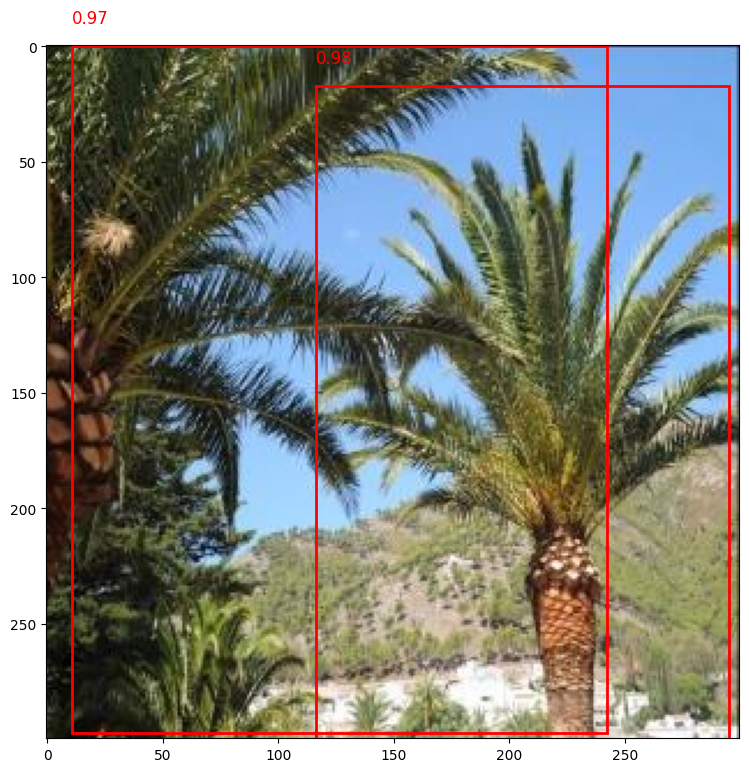

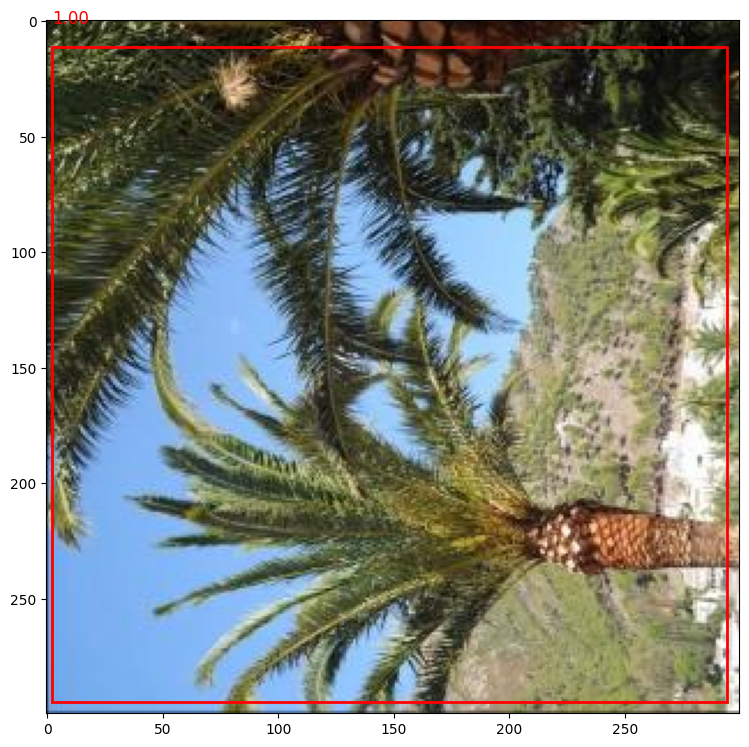

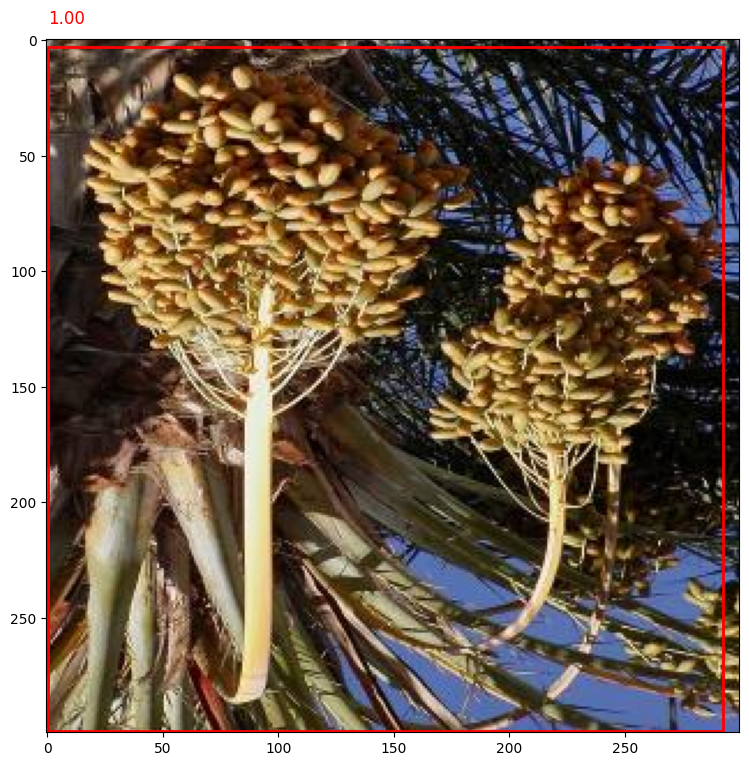

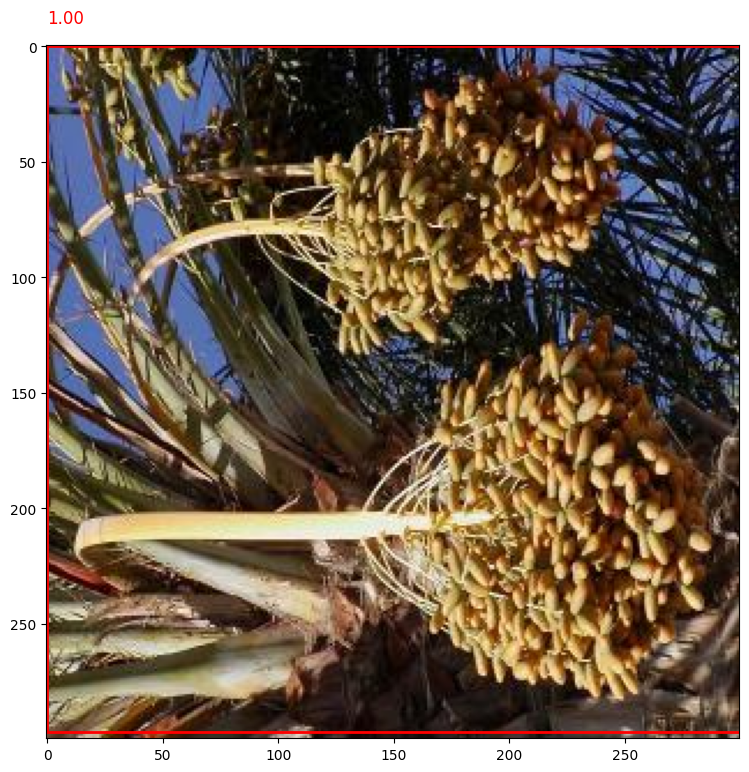

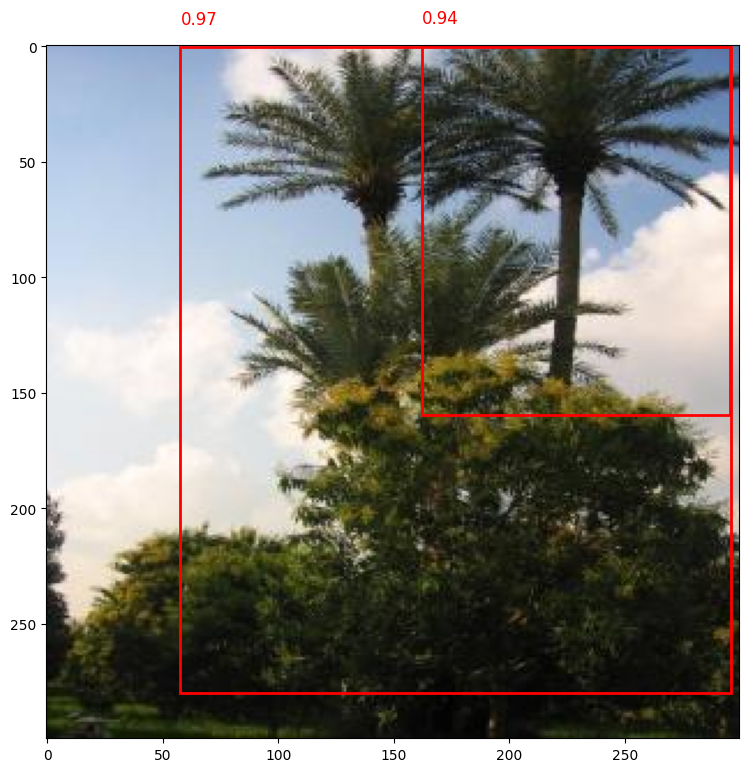

In [31]:
# Set the model to evaluation mode
model.eval()

# Disable gradient computation
torch.set_grad_enabled(False)

from torchvision.transforms.functional import to_pil_image
import matplotlib.patches as patches

def visualize_predictions(model, dataset, device, num_images=5, threshold=0.5):
    for i in range(num_images):
        img, _ = dataset[i]
        # Add batch dimension and move to device
        img = img.to(device)
        # Get predictions
        prediction = model([img])[0]

        # Move image and predictions back to CPU
        img = img.cpu()
        img = to_pil_image(img)
        boxes = prediction['boxes'].cpu().numpy()
        scores = prediction['scores'].cpu().numpy()
        labels = prediction['labels'].cpu().numpy()

        # Create a figure
        fig, ax = plt.subplots(1, figsize=(12, 9))
        ax.imshow(img)

        # Draw boxes
        for box, score, label in zip(boxes, scores, labels):
            if score > threshold:
                x_min, y_min, x_max, y_max = box
                rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                         linewidth=2, edgecolor='r', facecolor='none')
                ax.add_patch(rect)
                ax.text(x_min, y_min - 10, f'{score:.2f}', color='red', fontsize=12)

        plt.show()

# Visualize predictions
visualize_predictions(model, dataset_valid, device, num_images=5, threshold=0.5)


In [32]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'faster_rcnn_palm_tree.pth')


In [33]:
from google.colab import drive
drive.mount('/content/drive')

# Copy the model to Google Drive
!cp faster_rcnn_palm_tree.pth /content/drive/MyDrive/


Mounted at /content/drive


In [34]:
# Load the model structure
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None)

# Modify the model for your number of classes
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 2  # 1 class (palm tree) + background
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the saved state dictionary
model.load_state_dict(torch.load('faster_rcnn_palm_tree.pth'))

# Move the model to the device
model.to(device)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 139MB/s]
You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issu

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

In [ ]:
# Load from Google Drive
model.load_state_dict(torch.load('/content/drive/MyDrive/faster_rcnn_palm_tree.pth'))
